In [1]:
import tensorflow as tf
import csgd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = \
    mnist.load_data()
train_images = np.expand_dims(train_images, 3)
test_images = np.expand_dims(test_images, 3)
train_data = DataSet(train_images, train_labels, dtype=tf.float32, reshape=True)
test_data = DataSet(test_images, test_labels, dtype=tf.float32, reshape=True)

In [3]:
def mnist_model(optimizer, learning_rate, momentum):
    tf.reset_default_graph()

    # Build NN
    x = tf.placeholder(tf.float32, [None, 784], 'input')
    y = tf.placeholder(tf.int32, [None,], 'labels')
    out = tf.contrib.layers.fully_connected(x, 300)
    out = tf.contrib.layers.fully_connected(out, 10, activation_fn=None)
    y_one_hot = tf.one_hot(indices=tf.cast(y, tf.int32), depth=10)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_one_hot, logits=out))
    correct_prediction = tf.equal(tf.cast(tf.argmax(out, 1), tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Optimizer
    opt = optimizer(learning_rate=learning_rate, momentum=momentum)
    train_step = opt.minimize(loss)

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    def loss_and_acc(data, max_batch=1000):
        """ Return train/test loss/acc """
        ptr = 0
        l_sum, a_sum = 0, 0
        size = data.images.shape[0]
        while ptr < size:
            end = min(ptr+max_batch, size)
            feed_batch = {x: data.images[ptr:end],
                          y: data.labels[ptr:end]}
            l, a = sess.run([loss, accuracy], feed_batch)
            l_sum += (end-ptr)*l
            a_sum += (end-ptr)*a
            ptr = end
        return l_sum/size, a_sum/size 

    def train():
        """ Run train step """
        x_batch, y_batch = train_data.next_batch(100)
        feed_batch = {x: x_batch, y: y_batch}
        sess.run(train_step, feed_batch)
    
    return {
        'loss_and_acc': loss_and_acc,
        'train': train,
        'opt': opt,
        'sess': sess
    }

def run_model(model, num_iter=100000, num_out=200):
    """ Run model """
    chunk_size = num_iter // num_out
    assert chunk_size >= 1
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for t in range(num_iter):
        if t % chunk_size == 0:
            print('Epoch: ', t//chunk_size)
            temp1 = model['loss_and_acc'](train_data)
            temp2 = model['loss_and_acc'](test_data)
            train_losses.append(temp1[0])
            train_accs.append(temp1[1])
            test_losses.append(temp2[0])
            test_accs.append(temp2[1])
        model['train']()
    return np.asarray(train_losses), np.asarray(train_accs), \
            np.asarray(test_losses), np.asarray(test_accs)
        
def momentum_iterator(low, high, num):
    """ 
    Generate momentum 
    Grid search on log-scale
    """
    log_low = np.log10(1-high)
    log_high = np.log10(1-low)
    values = np.linspace(log_low, log_high, num)
    values = np.power(10, values)
    for v in values:
        yield 1-v

# cMSGD

In [4]:
num_test = 10
lr_low, lr_high = -4, -1
mom_low, mom_high = 0.9, 0.999
cmsgd_lrs, cmsgd_moms = [], []
cmsgd_train_losses, cmsgd_train_accs = [], []
cmsgd_test_losses, cmsgd_test_accs = [], []
iterator = momentum_iterator(mom_low, mom_high, num_test)
for n in range(num_test):
    print('Test: ', n)
#     learning_rate = sample_learning_rate(lr_low, lr_high)
    learning_rate = 0.01
    momentum = next(iterator)
#     momentum = sample_momentum(mom_low, mom_high)
    print('Sampled LR: ', learning_rate)
    print('Sampled Momentum: ', momentum)
    cmsgd_lrs.append(learning_rate)
    cmsgd_moms.append(momentum)
    model = mnist_model(csgd.CMSGDOptimizer, learning_rate, momentum)
    train_l, train_a, test_l, test_a = run_model(model)
    model['sess'].close()
    cmsgd_train_losses.append(train_l)
    cmsgd_train_accs.append(train_a)
    cmsgd_test_losses.append(test_l)
    cmsgd_test_accs.append(test_a)
cmsgd_train_losses = np.asarray(cmsgd_train_losses)
cmsgd_train_accs = np.asarray(cmsgd_train_accs)
cmsgd_test_losses = np.asarray(cmsgd_test_losses)
cmsgd_test_accs = np.asarray(cmsgd_test_accs)
cmsgd_lrs = np.asarray(cmsgd_lrs)
cmsgd_moms = np.asarray(cmsgd_moms)

Test:  0
Sampled LR:  0.01
Sampled Momentum:  0.999
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
E

Epoch:  100
Epoch:  101
Epoch:  102
Epoch:  103
Epoch:  104
Epoch:  105
Epoch:  106
Epoch:  107
Epoch:  108
Epoch:  109
Epoch:  110
Epoch:  111
Epoch:  112
Epoch:  113
Epoch:  114
Epoch:  115
Epoch:  116
Epoch:  117
Epoch:  118
Epoch:  119
Epoch:  120
Epoch:  121
Epoch:  122
Epoch:  123
Epoch:  124
Epoch:  125
Epoch:  126
Epoch:  127
Epoch:  128
Epoch:  129
Epoch:  130
Epoch:  131
Epoch:  132
Epoch:  133
Epoch:  134
Epoch:  135
Epoch:  136
Epoch:  137
Epoch:  138
Epoch:  139
Epoch:  140
Epoch:  141
Epoch:  142
Epoch:  143
Epoch:  144
Epoch:  145
Epoch:  146
Epoch:  147
Epoch:  148
Epoch:  149
Epoch:  150
Epoch:  151
Epoch:  152
Epoch:  153
Epoch:  154
Epoch:  155
Epoch:  156
Epoch:  157
Epoch:  158
Epoch:  159
Epoch:  160
Epoch:  161
Epoch:  162
Epoch:  163
Epoch:  164
Epoch:  165
Epoch:  166
Epoch:  167
Epoch:  168
Epoch:  169
Epoch:  170
Epoch:  171
Epoch:  172
Epoch:  173
Epoch:  174
Epoch:  175
Epoch:  176
Epoch:  177
Epoch:  178
Epoch:  179
Epoch:  180
Epoch:  181
Epoch:  182
Epoc

Epoch:  196
Epoch:  197
Epoch:  198
Epoch:  199
Test:  7
Sampled LR:  0.01
Sampled Momentum:  0.964061863362
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81

Final acc:
Train:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Test:  [ 0.98209999  0.9827      0.98099999  0.98069999  0.9813      0.9823
  0.98120001  0.9819      0.9813      0.9828    ]


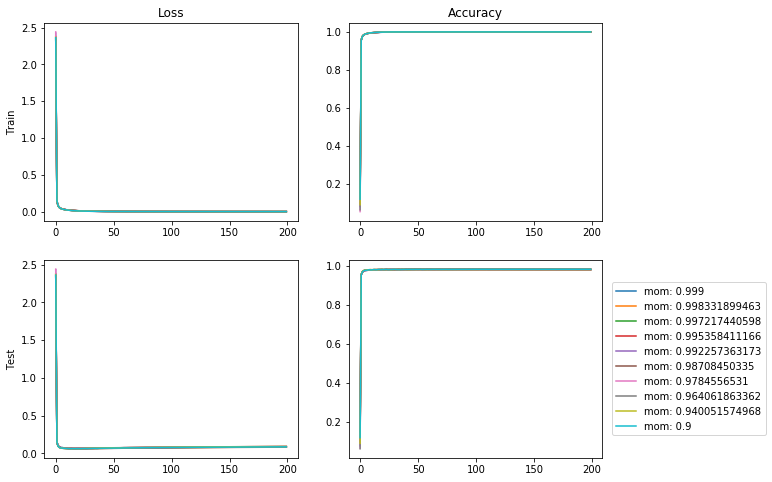

In [5]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for l in cmsgd_train_losses:
    ax[0,0].plot(l)
for a, lr in zip(cmsgd_train_accs, cmsgd_lrs):
    ax[0,1].plot(a, label='lr: '+str(lr))

for l in cmsgd_test_losses:
    ax[1,0].plot(l)
for a, lr, mom in zip(cmsgd_test_accs, cmsgd_lrs, cmsgd_moms):
    ax[1,1].plot(a, label='mom: '+str(mom))

ax[0,0].set_ylabel('Train')
ax[1,0].set_ylabel('Test')
ax[0,0].set_title('Loss')
ax[0,1].set_title('Accuracy')
    
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
print('Final acc:')
print('Train: ', cmsgd_train_accs[:,-1])
print('Test: ', cmsgd_test_accs[:,-1])

# MSGD

In [6]:
num_test = 10
lr_low, lr_high = -4, -1
mom_low, mom_high = 0.9, 0.999
msgd_lrs, msgd_moms = [], []
msgd_train_losses, msgd_train_accs = [], []
msgd_test_losses, msgd_test_accs = [], []
iterator = momentum_iterator(mom_low, mom_high, num_test)
for n in range(num_test):
    print('Test: ', n)
#     learning_rate = sample_learning_rate(lr_low, lr_high)
    learning_rate = 0.01
#     momentum = sample_momentum(mom_low, mom_high)
    momentum = next(iterator)
    print('Sampled LR: ', learning_rate)
    print('Sampled Momentum: ', momentum)
    msgd_lrs.append(learning_rate)
    msgd_moms.append(momentum)
    model = mnist_model(tf.train.MomentumOptimizer, learning_rate, momentum)
    train_l, train_a, test_l, test_a = run_model(model)
    model['sess'].close()
    msgd_train_losses.append(train_l)
    msgd_train_accs.append(train_a)
    msgd_test_losses.append(test_l)
    msgd_test_accs.append(test_a)
msgd_train_losses = np.asarray(msgd_train_losses)
msgd_train_accs = np.asarray(msgd_train_accs)
msgd_test_losses = np.asarray(msgd_test_losses)
msgd_test_accs = np.asarray(msgd_test_accs)
msgd_lrs = np.asarray(msgd_lrs)
msgd_moms = np.asarray(msgd_moms)

Test:  0
Sampled LR:  0.01
Sampled Momentum:  0.999
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
E

Epoch:  100
Epoch:  101
Epoch:  102
Epoch:  103
Epoch:  104
Epoch:  105
Epoch:  106
Epoch:  107
Epoch:  108
Epoch:  109
Epoch:  110
Epoch:  111
Epoch:  112
Epoch:  113
Epoch:  114
Epoch:  115
Epoch:  116
Epoch:  117
Epoch:  118
Epoch:  119
Epoch:  120
Epoch:  121
Epoch:  122
Epoch:  123
Epoch:  124
Epoch:  125
Epoch:  126
Epoch:  127
Epoch:  128
Epoch:  129
Epoch:  130
Epoch:  131
Epoch:  132
Epoch:  133
Epoch:  134
Epoch:  135
Epoch:  136
Epoch:  137
Epoch:  138
Epoch:  139
Epoch:  140
Epoch:  141
Epoch:  142
Epoch:  143
Epoch:  144
Epoch:  145
Epoch:  146
Epoch:  147
Epoch:  148
Epoch:  149
Epoch:  150
Epoch:  151
Epoch:  152
Epoch:  153
Epoch:  154
Epoch:  155
Epoch:  156
Epoch:  157
Epoch:  158
Epoch:  159
Epoch:  160
Epoch:  161
Epoch:  162
Epoch:  163
Epoch:  164
Epoch:  165
Epoch:  166
Epoch:  167
Epoch:  168
Epoch:  169
Epoch:  170
Epoch:  171
Epoch:  172
Epoch:  173
Epoch:  174
Epoch:  175
Epoch:  176
Epoch:  177
Epoch:  178
Epoch:  179
Epoch:  180
Epoch:  181
Epoch:  182
Epoc

Epoch:  196
Epoch:  197
Epoch:  198
Epoch:  199
Test:  7
Sampled LR:  0.01
Sampled Momentum:  0.964061863362
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81

Final acc:
Train:  [ 0.50853333  0.95221666  0.99254999  1.          1.          1.          1.
  1.          1.          1.        ]
Test:  [ 0.5075      0.9326      0.96589999  0.97950001  0.9825      0.98339999
  0.98340001  0.9827      0.9816      0.9821    ]


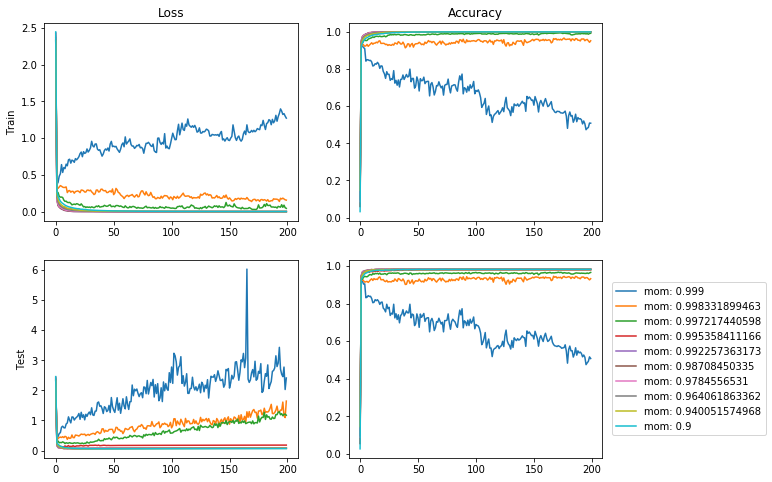

In [7]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for l in msgd_train_losses:
    ax[0,0].plot(l)
for a, lr in zip(msgd_train_accs, msgd_lrs):
    ax[0,1].plot(a, label='lr: '+str(lr))

for l in msgd_test_losses:
    ax[1,0].plot(l)
for a, lr, mom in zip(msgd_test_accs, msgd_lrs, msgd_moms):
    ax[1,1].plot(a, label='mom: '+str(mom))

ax[0,0].set_ylabel('Train')
ax[1,0].set_ylabel('Test')
ax[0,0].set_title('Loss')
ax[0,1].set_title('Accuracy')
    
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
print('Final acc:')
print('Train: ', msgd_train_accs[:,-1])
print('Test: ', msgd_test_accs[:,-1])